# Ejecución de modelo base

- [1] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” CoRR, vol. abs/1505.0, 2015.
- [1] J. Akeret, C. Chang, A. Lucchi, and A. Refregier, “Radio frequency interference mitigation using deep convolutional neural networks,” Astron. Comput., vol. 18, pp. 35–39, 2017.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import tensorflow as tf
import logging
from collections import OrderedDict
import os
import shutil
from PIL import Image
import h5py
import tifffile #pip install tifffile

C:\Users\Kevin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Implementación de tf_unet
- Obtenido de (Akered, 2017)
- Código: https://github.com/jakeret/tf_unet

### util.py
Obtenido de (Akered, 2017)

In [3]:
def plot_prediction(x_test, y_test, prediction, save=False):
    import matplotlib
    import matplotlib.pyplot as plt
    
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_2d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()

def to_rgb(img):
    """
    Converts the given array into a RGB image. If the number of channels is not
    3 the array is tiled such that it has 3 channels. Finally, the values are
    rescaled to [0,255) 
    
    :param img: the array to convert [nx, ny, channels]
    
    :returns img: the rgb image [nx, ny, 3]
    """
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:
        img = np.tile(img, 3)
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255
    return img

def crop_to_shape(data, shape):
    """
    Crops the array to the given image shape by removing the border (expects a tensor of shape [batches, nx, ny, channels].
    
    :param data: the array to crop
    :param shape: the target shape
    """
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    return data[:, offset0:(-offset0), offset1:(-offset1)]

def combine_img_prediction(data, gt, pred):
    """
    Combines the data, grouth thruth and the prediction into one rgb image
    
    :param data: the data tensor
    :param gt: the ground thruth tensor
    :param pred: the prediction tensor
    
    :returns img: the concatenated rgb image 
    """
    ny = pred.shape[2]
    ch = data.shape[3]
    img = np.concatenate((to_rgb(crop_to_shape(data, pred.shape).reshape(-1, ny, ch)), 
                          to_rgb(crop_to_shape(gt[..., 1], pred.shape).reshape(-1, ny, 1)), 
                          to_rgb(pred[..., 1].reshape(-1, ny, 1))), axis=1)
    return img

def save_image(img, path):
    """
    Writes the image to disk
    
    :param img: the rgb image to save
    :param path: the target path
    """
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'JPEG', dpi=[300,300], quality=90)

### layers.py
Obtenido de (Akered, 2017)

In [4]:
def weight_variable(shape, stddev=0.1, name="weight"):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)

def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)

def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)

def deconv2d(x, W,stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)

def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")

### Unet
Obtenido de (Akered, 2017)

In [5]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
                    summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.

    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """

    logging.info(
        "Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(
            layers=layers,
            features=features_root,
            filter_size=filter_size,
            pool_size=pool_size))

    # Placeholder for the input image
    with tf.name_scope("preprocessing"):
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        x_image = tf.reshape(x, tf.stack([-1, nx, ny, channels]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]

    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()

    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        with tf.name_scope("down_conv_{}".format(str(layer))):
            features = 2 ** layer * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            if layer == 0:
                w1 = weight_variable([filter_size, filter_size, channels, features], stddev, name="w1")
            else:
                w1 = weight_variable([filter_size, filter_size, features // 2, features], stddev, name="w1")

            w2 = weight_variable([filter_size, filter_size, features, features], stddev, name="w2")
            b1 = bias_variable([features], name="b1")
            b2 = bias_variable([features], name="b2")

            conv1 = conv2d(in_node, w1, b1, keep_prob)
            tmp_h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(tmp_h_conv, w2, b2, keep_prob)
            dw_h_convs[layer] = tf.nn.relu(conv2)

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size -= 4
            if layer < layers - 1:
                pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                in_node = pools[layer]
                size /= 2

    in_node = dw_h_convs[layers - 1]

    # up layers
    for layer in range(layers - 2, -1, -1):
        with tf.name_scope("up_conv_{}".format(str(layer))):
            features = 2 ** (layer + 1) * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))

            wd = weight_variable_devonc([pool_size, pool_size, features // 2, features], stddev, name="wd")
            bd = bias_variable([features // 2], name="bd")
            h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
            h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
            deconv[layer] = h_deconv_concat

            w1 = weight_variable([filter_size, filter_size, features, features // 2], stddev, name="w1")
            w2 = weight_variable([filter_size, filter_size, features // 2, features // 2], stddev, name="w2")
            b1 = bias_variable([features // 2], name="b1")
            b2 = bias_variable([features // 2], name="b2")

            conv1 = conv2d(h_deconv_concat, w1, b1, keep_prob)
            h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(h_conv, w2, b2, keep_prob)
            in_node = tf.nn.relu(conv2)
            up_h_convs[layer] = in_node

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size *= 2
            size -= 4

    # Output Map
    with tf.name_scope("output_map"):
        weight = weight_variable([1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class], name="bias")
        conv = conv2d(in_node, weight, bias, tf.constant(1.0))
        output_map = tf.nn.relu(conv)
        up_h_convs["out"] = output_map

    if summaries:
        with tf.name_scope("summaries"):
            for i, (c1, c2) in enumerate(convs):
                tf.summary.image('summary_conv_%02d_01' % i, get_image_summary(c1))
                tf.summary.image('summary_conv_%02d_02' % i, get_image_summary(c2))

            for k in pools.keys():
                tf.summary.image('summary_pool_%02d' % k, get_image_summary(pools[k]))

            for k in deconv.keys():
                tf.summary.image('summary_deconv_concat_%02d' % k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%02d" % k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s" % k + '/activations', up_h_convs[k])

    variables = []
    for w1, w2 in weights:
        variables.append(w1)
        variables.append(w2)

    for b1, b2 in biases:
        variables.append(b1)
        variables.append(b2)

    return output_map, variables, int(in_size - size)

In [6]:
class Unet(object):
    """
    A unet implementation

    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """

    def __init__(self, channels=3, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        self.y = tf.placeholder("float", shape=[None, None, None, n_class], name="y")
        self.keep_prob = tf.placeholder(tf.float32, name="dropout_probability")  # dropout (keep probability)

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)

        self.cost = self._get_cost(logits, cost, cost_kwargs)

        self.gradients_node = tf.gradients(self.cost, self.variables)

        with tf.name_scope("cross_entropy"):
            self.cross_entropy = cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                               tf.reshape(pixel_wise_softmax(logits), [-1, n_class]))

        with tf.name_scope("results"):
            self.predicter = pixel_wise_softmax(logits)
            self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are:
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """

        with tf.name_scope("cost"):
            flat_logits = tf.reshape(logits, [-1, self.n_class])
            flat_labels = tf.reshape(self.y, [-1, self.n_class])
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights)
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                          labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map)

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                                     labels=flat_labels))
            elif cost_name == "dice_coefficient":
                eps = 1e-5
                prediction = pixel_wise_softmax(logits)
                intersection = tf.reduce_sum(prediction * self.y)
                union = eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
                loss = -(2 * intersection / (union))

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

            return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data

        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2)
        """

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)

            # Restore model weights from previously saved model
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction

    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint

        :param sess: current session
        :param model_path: path to file system location
        """

        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint

        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """

        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [7]:
def _update_avg_gradients(avg_gradients, gradients, step):
    if avg_gradients is None:
        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
    for i in range(len(gradients)):
        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step + 1)))) + (gradients[i] / (step + 1))

    return avg_gradients


def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
            100.0 *
            np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
            (predictions.shape[0] * predictions.shape[1] * predictions.shape[2]))


def get_image_summary(img, idx=0):
    """
    Make an image summary for 4d tensor image with index idx
    """

    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255

    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

In [8]:
class Trainer(object):
    """
    Trains a unet instance

    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param verification_batch_size: size of verification batch
    :param norm_grads: (optional) true if normalized gradients should be added to the summaries
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer

    """

    def __init__(self, net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.verification_batch_size = verification_batch_size
        self.norm_grads = norm_grads
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs

    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)

            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate,
                                                                 global_step=global_step,
                                                                 decay_steps=training_iters,
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)

            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,
                                                                               global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate, name="learning_rate")

            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node,
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                           global_step=global_step)

        return optimizer

    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0, name="global_step")

        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]), name="norm_gradients")

        if self.net.summaries and self.norm_grads:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()
        init = tf.global_variables_initializer()

        self.prediction_path = prediction_path
        abs_prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)

        if not restore:
            logging.info("Removing '{:}'".format(abs_prediction_path))
            shutil.rmtree(abs_prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)

        if not os.path.exists(abs_prediction_path):
            logging.info("Allocating '{:}'".format(abs_prediction_path))
            os.makedirs(abs_prediction_path)

        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)

        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1,
              restore=False, write_graph=False, prediction_path='prediction'):
        """
        Lauches the training process

        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored
        :param write_graph: Flag if the computation graph should be written as protobuf file to the output path
        :param prediction_path: path where to save predictions on each epoch
        """
        save_path = os.path.join(output_path, "model.ckpt")
        if epochs == 0:
            return save_path

        init = self._initialize(training_iters, output_path, restore, prediction_path)

        with tf.Session() as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)

            sess.run(init)

            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)

            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")

            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")

            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch * training_iters), ((epoch + 1) * training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)

                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run(
                        (self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node),
                        feed_dict={self.net.x: batch_x,
                                   self.net.y: crop_to_shape(batch_y, pred_shape),
                                   self.net.keep_prob: dropout})

                    if self.net.summaries and self.norm_grads:
                        avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
                        norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                        self.norm_gradients_node.assign(norm_gradients).eval()

                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x,
                                                    crop_to_shape(batch_y, pred_shape))

                    total_loss += loss

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                self.store_prediction(sess, test_x, test_y, "epoch_%s" % epoch)

                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")

            return save_path

    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,
                                                             self.net.y: batch_y,
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape

        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x,
                                                  self.net.y: crop_to_shape(batch_y, pred_shape),
                                                  self.net.keep_prob: 1.})

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                                   crop_to_shape(batch_y,
                                                                                                      prediction.shape)),
                                                                        loss))

        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg" % (self.prediction_path, name))

        return pred_shape

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info(
            "Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        summary_str, loss, acc, predictions = sess.run([self.summary_op,
                                                        self.net.cost,
                                                        self.net.accuracy,
                                                        self.net.predicter],
                                                       feed_dict={self.net.x: batch_x,
                                                                  self.net.y: batch_y,
                                                                  self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info(
            "Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                           loss,
                                                                                                           acc,
                                                                                                           error_rate(
                                                                                                               predictions,
                                                                                                               batch_y)))
    

### image_util
Obtenido de (Akered, 2017)

In [9]:
class BaseDataProvider(object):
    """
    Abstract base class for DataProvider implementation. Subclasses have to
    overwrite the `_next_data` method that load the next data and label array.
    This implementation automatically clips the data with the given min/max and
    normalizes the values to (0,1]. To change this behavoir the `_process_data`
    method can be overwritten. To enable some post processing such as data
    augmentation the `_post_process` method can be overwritten.

    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping

    """
    channels = 1
    n_class = 2    
    
    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf
        
    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx = train_data.shape[1]
        ny = train_data.shape[0]  
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        
        :param data: the data array
        :param labels: the label array
        """
        return data, labels        
        
    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
    
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
    
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
    
        return X, Y        

In [10]:
class SimpleDataProvider(BaseDataProvider):
    """
    A simple data provider for numpy arrays. 
    Assumes that the data and label are numpy array with the dimensions
    data `[n, X, Y, channels]`, label `[n, X, Y, classes]`. Where
    `n` is the number of images, `X`, `Y` the size of the image.

    :param data: data numpy array. Shape=[n, X, Y, channels]
    :param label: label numpy array. Shape=[n, X, Y, classes]
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, data, label, a_min=None, a_max=None, channels=1, n_class = 2):
        super(SimpleDataProvider, self).__init__(a_min, a_max)
        self.data = data
        self.label = label
        self.file_count = data.shape[0]
        self.n_class = n_class
        self.channels = channels

    def _next_data(self):
        idx = np.random.choice(self.file_count)
        return self.data[idx], self.label[idx]

In [11]:
class ImageDataProvider(BaseDataProvider):
    """
    Generic data provider for images, supports gray scale and colored images.
    Assumes that the data images and label images are stored in the same folder
    and that the labels have a different file suffix 
    e.g. 'train/fish_1.tif' and 'train/fish_1_mask.tif'

    Usage:
    data_provider = ImageDataProvider("..fishes/train/*.tif")
        
    :param search_path: a glob search pattern to find all data and label images
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param data_suffix: suffix pattern for the data images. Default '.tif'
    :param mask_suffix: suffix pattern for the label images. Default '_mask.tif'
    :param shuffle_data: if the order of the loaded file path should be randomized. Default 'True'
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif', shuffle_data=True, n_class = 2):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        self.data_suffix = data_suffix
        self.mask_suffix = mask_suffix
        self.file_idx = -1
        self.shuffle_data = shuffle_data
        self.n_class = n_class
        
        self.data_files = self._find_data_files(search_path)
        
        if self.shuffle_data:
            np.random.shuffle(self.data_files)
        
        assert len(self.data_files) > 0, "No training files"
        print("Number of files used: %s" % len(self.data_files))
        
        img = self._load_file(self.data_files[0])
        self.channels = 1 if len(img.shape) == 2 else img.shape[-1]
        
    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return [name for name in all_files if self.data_suffix in name and not self.mask_suffix in name]
    
    
    def _load_file(self, path, dtype=np.float32):
        return np.array(Image.open(path), dtype)
        # return np.squeeze(cv2.imread(image_name, cv2.IMREAD_GRAYSCALE))

    def _cylce_file(self):
        self.file_idx += 1
        if self.file_idx >= len(self.data_files):
            self.file_idx = 0 
            if self.shuffle_data:
                np.random.shuffle(self.data_files)
        
    def _next_data(self):
        self._cylce_file()
        image_name = self.data_files[self.file_idx]
        label_name = image_name.replace(self.data_suffix, self.mask_suffix)
        
        img = self._load_file(image_name, np.float32)
        label = self._load_file(label_name, np.bool)
    
        return img,label

### image_gen
Obtenido de (Akered, 2017)

In [12]:
def create_image_and_label(nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
        image = np.ones((nx, ny, 1))
        label = np.zeros((nx, ny, 3), dtype=np.bool)
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt):
            a = np.random.randint(border, nx-border)
            b = np.random.randint(border, ny-border)
            r = np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            y,x = np.ogrid[-a:nx-a, -b:ny-b]
            m = x*x + y*y <= r*r
            mask = np.logical_or(mask, m)

            image[m] = h

        label[mask, 1] = 1

        if rectangles:
            mask = np.zeros((nx, ny), dtype=np.bool)
            for _ in range(cnt//2):
                a = np.random.randint(nx)
                b = np.random.randint(ny)
                r =  np.random.randint(r_min, r_max)
                h = np.random.randint(1,255)

                m = np.zeros((nx, ny), dtype=np.bool)
                m[a:a+r, b:b+r] = True
                mask = np.logical_or(mask, m)
                image[m] = h

            label[mask, 2] = 1

            label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

        image += np.random.normal(scale=sigma, size=image.shape)
        image -= np.amin(image)
        image /= np.amax(image)

        if rectangles:
            return image, label
        else:
            return image, label[..., 1] 

In [13]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        print("init");
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)   

## demos
Demos obtenidos del repositorio https://github.com/jakeret/tf_unet

### demo_toy_problem

In [14]:
nx = 572
ny = 572
plt.rcParams['image.cmap'] = 'gist_earth'
np.random.seed(98765)

In [15]:
data_provider = GrayScaleDataProvider(nx, ny, cnt=20)

init


In [16]:
x_test, y_test = data_provider(1)

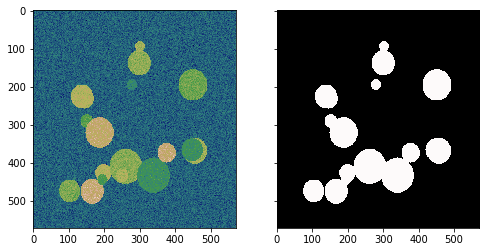

In [17]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [18]:
net = Unet(channels=data_provider.channels, n_class=data_provider.n_class, layers=3, features_root=16)

2018-09-25 12:59:02,073 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [19]:
trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [20]:
#Original: 10 épocas training_iters=32
path = trainer.train(data_provider, "./unet_trained", training_iters=16, epochs=1, display_step=2)

2018-09-25 12:59:03,133 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction'
2018-09-25 12:59:03,137 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained'
2018-09-25 12:59:03,145 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction'
2018-09-25 12:59:03,147 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained'
2018-09-25 12:59:09,763 Verification error= 17.3%, loss= 0.6844
2018-09-25 12:59:10,411 Start optimization
2018-09-25 12:59:15,001 Iter 0, Minibatch Loss= 0.6339, Training Accuracy= 0.8080, Minibatch error= 19.2%
2018-09-25 12:59:22,232 Iter 2, Minibatch Loss= 0.5285, Training Accuracy= 0.8856, Minibatch error= 11.4%
2018-09-25 12:59:29,516 Iter 4, Minibatch Loss= 0.5251, Training Accuracy= 0.8146, Minibatch error= 18.5%
2018-09-25 12:59:36,670 Iter 6, Minibatch Loss= 0.4384, Training Accuracy= 0.8623, Minibatch error= 13.8%
2018-09-25 12:59:43,916 I

In [21]:
x_test, y_test = data_provider(1)
prediction = net.predict("./unet_trained/model.ckpt", x_test)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2018-09-25 13:00:15,872 Restoring parameters from ./unet_trained/model.ckpt
2018-09-25 13:00:15,921 Model restored from file: ./unet_trained/model.ckpt


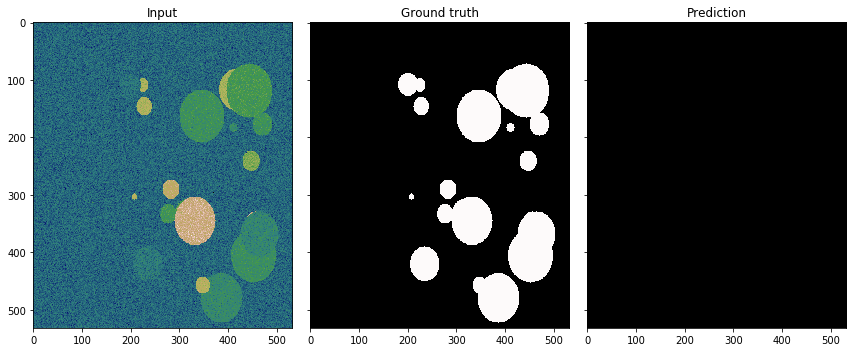

In [22]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
mask = prediction[0,...,1] > 0.9
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")
fig.tight_layout()
fig.savefig("img/toy_problem.png")

## EM segmentation challenge - ISBI 2012
- http://brainiac2.mit.edu/isbi_challenge/

In [34]:
PATH_ISBI_2010_ORIGINAL = "dataset/isbi-challenge/original/"
PATH_ISBI_2010_TRAIN = "dataset/isbi-challenge/train/"
PATH_ISBI_2010_TEST = "dataset/isbi-challenge/test/"

Obtenido de 
- https://github.com/A-Jacobson/Unet/blob/master/datasets.py

In [24]:
class ISBI2012Dataset():
    def __init__(self, path_img, path_target, transforms=None):
        self.train = np.expand_dims(tifffile.TiffFile(path_img).asarray(), axis=-1)
        self.targets = np.expand_dims(tifffile.TiffFile(path_target).asarray(), axis=-1)
        self.transforms = transforms

    def __len__(self):
        return len(self.train)

    def __getitem__(self, idx):
        img = self.train[idx]
        target = self.targets[idx]

        if self.transforms:
            img = self.transforms(img)
            target = self.transforms(target)

        return img, target

In [25]:
isbi = ISBI2012Dataset(PATH_ISBI_2010_ORIGINAL + 'train-volume.tif', PATH_ISBI_2010_ORIGINAL+ 'train-labels.tif')

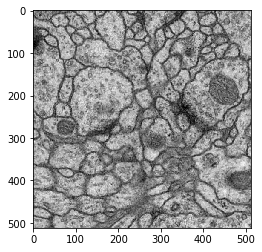

In [26]:
plt.imshow(isbi.train[0].reshape(512, 512), cmap='gray');

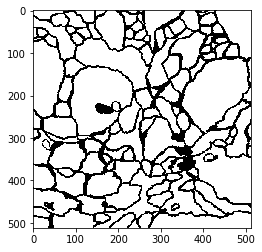

In [27]:
plt.imshow(isbi.targets[0].reshape(512, 512) , cmap='gray');

Obtenido de (Akered, 2017)
- https://github.com/jakeret/tf_unet

In [28]:
data_provider = ImageDataProvider(PATH_ISBI_2010_TRAIN + "*.tif")

Number of files used: 1


In [29]:
x_test, y_test = data_provider(1)

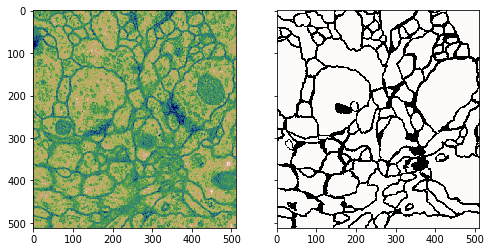

In [30]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [31]:
net = Unet(channels=data_provider.channels, n_class=data_provider.n_class, layers=3, features_root=16)

2018-09-25 13:00:17,990 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [32]:
trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [33]:
#Original: 10 épocas training_iters=32
path = trainer.train(data_provider, "./unet_trained_isbi", training_iters=32, epochs=10, display_step=2)

2018-09-25 13:00:19,046 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction'
2018-09-25 13:00:19,049 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_isbi'
2018-09-25 13:00:19,062 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction'
2018-09-25 13:00:19,064 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_isbi'
2018-09-25 13:00:24,123 Verification error= 23.1%, loss= 0.6887
2018-09-25 13:00:24,644 Start optimization
2018-09-25 13:00:28,458 Iter 0, Minibatch Loss= 0.6445, Training Accuracy= 0.7707, Minibatch error= 22.9%
2018-09-25 13:00:34,144 Iter 2, Minibatch Loss= 0.6042, Training Accuracy= 0.7707, Minibatch error= 22.9%
2018-09-25 13:00:39,932 Iter 4, Minibatch Loss= 0.5725, Training Accuracy= 0.7707, Minibatch error= 22.9%
2018-09-25 13:00:45,887 Iter 6, Minibatch Loss= 0.5432, Training Accuracy= 0.7707, Minibatch error= 22.9%
2018-09-25 13:0

2018-09-25 13:07:11,121 Iter 132, Minibatch Loss= 0.3255, Training Accuracy= 0.8322, Minibatch error= 16.8%
2018-09-25 13:07:17,008 Iter 134, Minibatch Loss= 0.3256, Training Accuracy= 0.8336, Minibatch error= 16.6%
2018-09-25 13:07:22,869 Iter 136, Minibatch Loss= 0.3265, Training Accuracy= 0.8348, Minibatch error= 16.5%
2018-09-25 13:07:28,649 Iter 138, Minibatch Loss= 0.3271, Training Accuracy= 0.8350, Minibatch error= 16.5%
2018-09-25 13:07:34,425 Iter 140, Minibatch Loss= 0.3267, Training Accuracy= 0.8354, Minibatch error= 16.5%
2018-09-25 13:07:40,175 Iter 142, Minibatch Loss= 0.3270, Training Accuracy= 0.8356, Minibatch error= 16.4%
2018-09-25 13:07:46,075 Iter 144, Minibatch Loss= 0.3286, Training Accuracy= 0.8353, Minibatch error= 16.5%
2018-09-25 13:07:52,032 Iter 146, Minibatch Loss= 0.3291, Training Accuracy= 0.8353, Minibatch error= 16.5%
2018-09-25 13:07:58,081 Iter 148, Minibatch Loss= 0.3307, Training Accuracy= 0.8339, Minibatch error= 16.6%
2018-09-25 13:08:04,246 Iter

2018-09-25 13:14:31,207 Iter 274, Minibatch Loss= 0.3107, Training Accuracy= 0.8472, Minibatch error= 15.3%
2018-09-25 13:14:36,972 Iter 276, Minibatch Loss= 0.3101, Training Accuracy= 0.8468, Minibatch error= 15.3%
2018-09-25 13:14:42,815 Iter 278, Minibatch Loss= 0.3104, Training Accuracy= 0.8472, Minibatch error= 15.3%
2018-09-25 13:14:48,634 Iter 280, Minibatch Loss= 0.3104, Training Accuracy= 0.8472, Minibatch error= 15.3%
2018-09-25 13:14:54,354 Iter 282, Minibatch Loss= 0.3108, Training Accuracy= 0.8472, Minibatch error= 15.3%
2018-09-25 13:15:00,076 Iter 284, Minibatch Loss= 0.3115, Training Accuracy= 0.8475, Minibatch error= 15.3%
2018-09-25 13:15:05,943 Iter 286, Minibatch Loss= 0.3118, Training Accuracy= 0.8476, Minibatch error= 15.2%
2018-09-25 13:15:08,447 Epoch 8, Average loss: 0.3173, learning rate: 0.1327
2018-09-25 13:15:13,144 Verification error= 15.4%, loss= 0.3086
2018-09-25 13:15:17,181 Iter 288, Minibatch Loss= 0.3122, Training Accuracy= 0.8477, Minibatch error= 1

Test

In [37]:
data_provider = ImageDataProvider(PATH_ISBI_2010_TEST + "*.tif")
x_test, y_test = data_provider(1)

Number of files used: 1


In [38]:
prediction = net.predict(path, x_test)

INFO:tensorflow:Restoring parameters from ./unet_trained_isbi\model.ckpt


2018-09-25 13:22:27,512 Restoring parameters from ./unet_trained_isbi\model.ckpt
2018-09-25 13:22:27,572 Model restored from file: ./unet_trained_isbi\model.ckpt


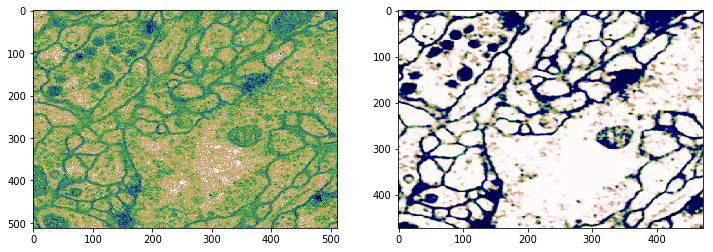

In [43]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(prediction[0,...,1], aspect="auto")